# Open Source Data Analysis- Time Series

This analysis is using the available Zillow Data found on Nasdaq Datalink

### 1) Importing Libraries and Data

Attempted to use the API to bring in the data but wasn't able to get it over. I kept getting 403 errors. I went ahead and downloaded it and uploaded it normally. I think my firewall was preventing the API from being added- I even allowed it through Windows Defender without any luck.

import os
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "MY API (KEY REMOVED FOR PRIVACY)"

data = nasdaqdatalink.get("ZILLOW/DATA")
print(data.head())

import requests

try:
    r = requests.get("https://data.nasdaq.com/api/v3/datasets/FRED/GDP/data.json")
    print(r.status_code)
except Exception as e:
    print("Error:", e)

In [68]:
#import libraries
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

#creating Paths
path= r'C:\Users\wjzak\Dropbox\Career Foundry\Data Immersion\Module 6- Advanced Analytics & Dashboard Design\\'

#using the path to pull file name and read the clean products data
df_data = pd.read_csv(os.path.join(path, 'ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf', 'ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv'), index_col = False)
df_region = pd.read_csv(os.path.join(path, 'ZILLOW_REGIONS_1a51d107db038a83ac171d604cb48d5b', 'ZILLOW_REGIONS_1a51d107db038a83ac171d604cb48d5b.csv'), index_col = False)

### 2) Merge with Regional Data

In [69]:
df_data.head()

,indicator_id,region_id,date,value
0,ZATT,3101,1998-01-31,338849.0
1,ZATT,3101,1998-02-28,342993.0
2,ZATT,3101,1998-03-31,346763.0
3,ZATT,3101,1998-04-30,349356.0
4,ZATT,3101,1998-05-31,351981.0


In [70]:
df_region.head()

,region_id,region_type,region
0,96208,zip,"90706;CA;Los Angeles-Long Beach-Anaheim, CA;Be..."
1,394415,metro,"Bridgeport, CT"
2,394653,metro,"Greenville, SC"
3,394312,metro,"Albuquerque, NM"
4,394357,metro,"Bakersfield, CA"


In [71]:
df_merge = pd.merge(df_data, df_region, on='region_id', how='inner') 
df_merge.head()

,indicator_id,region_id,date,value,region_type,region
0,ZATT,3101,1998-01-31,338849.0,county,Los Angeles County;CA;Los Angeles-Long Beach-A...
1,ZATT,3101,1998-02-28,342993.0,county,Los Angeles County;CA;Los Angeles-Long Beach-A...
2,ZATT,3101,1998-03-31,346763.0,county,Los Angeles County;CA;Los Angeles-Long Beach-A...
3,ZATT,3101,1998-04-30,349356.0,county,Los Angeles County;CA;Los Angeles-Long Beach-A...
4,ZATT,3101,1998-05-31,351981.0,county,Los Angeles County;CA;Los Angeles-Long Beach-A...


In [72]:
df_merge.shape

(159663189, 6)

In [73]:
df_merge.columns

Index(['indicator_id', 'region_id', 'date', 'value', 'region_type', 'region'], dtype='object')

In [74]:
df_merge['date'] = pd.to_datetime(df_merge['date'])

### 2) Subsetting and Wrangling Data

In [77]:
df_data.drop(columns=['indicator_id', 'region_id'], inplace=True)

In [75]:
#Check for missing values
df_data.isnull().sum() 

indicator_id    0
region_id       0
date            0
value           0
dtype: int64

In [76]:
#Check for duplicates
dups = df_data.duplicated()
dups.sum()

np.int64(0)

In [78]:
df_data['date'] = pd.to_datetime(df_data['date'], errors='coerce')
df_data = df_data.dropna(subset=['date'])

In [79]:
df_data = df_data[(df_data['date'] >= pd.Timestamp('0001-01-01')) & 
        (df_data['date'] <= pd.Timestamp('9999-12-31'))]

In [80]:
#down sample the data to use on this task since it has a ton of data
df_data = df_data.iloc[::10000, :]

This was my only "Subsetting" there were too many data points and my pc was crashing trying to plot everything.

In [81]:
#plt.figure(figsize=(15,5), dpi=100)
#plt.plot(df_data)

This plot was not responding to what I was trying to complete. I went ahead and used a more intricate one.

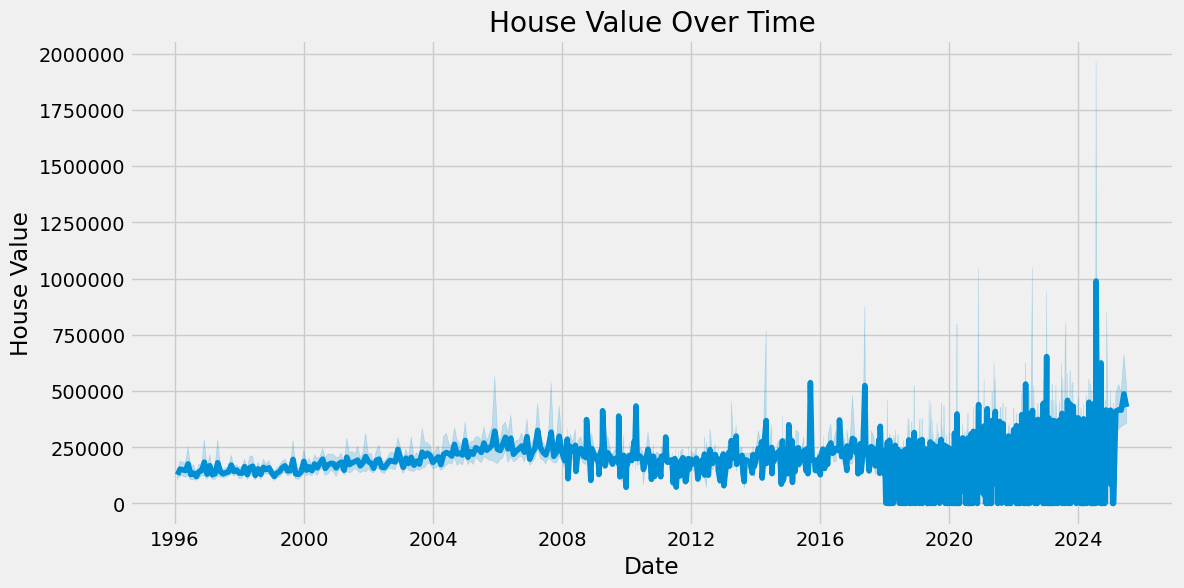

In [82]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_data, x='date', y='value')

plt.xlabel('Date')
plt.ylabel('House Value')
plt.title('House Value Over Time')
plt.grid(True)

plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.show()

In [83]:
# Set the "Date" column as the index

from datetime import datetime

df_data['datetime'] = pd.to_datetime(df_data['date']) # Create a datetime column from "Date.""
df_data = df_data.set_index('datetime') # Set the datetime as the index of the dataframe.
df_data.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_data.head()

,value
datetime,
1998-01-31,338849.000000
1998-03-31,195915.000000
1998-05-31,188154.000000
1998-07-31,556111.000000
2004-02-29,235036.237472


In [84]:
# Check for missing values (you shouldn't have any)

df_data.isnull().sum() 

value    0
dtype: int64

In [85]:
# Check for duplicates

dups = df_data.duplicated()
dups.sum()

# No dups!

np.int64(485)

### 3) Decomposition

In [86]:
#Ensure no duplicates
decomp_data = df_data[~df_data.index.duplicated(keep='first')]

#If currently a PeriodIndex → convert back to DatetimeIndex
if isinstance(decomp_data.index, pd.PeriodIndex):
    decomp_data.index = decomp_data.index.to_timestamp('M')

#Assign monthly frequency if needed
decomp_data = decomp_data.asfreq('M')

#Drop Missing
df_clean = decomp_data.dropna()

In [87]:
# Decompose the time series
from statsmodels.tsa.seasonal import STL

stl = STL(decomp_data, period=12)     # monthly data
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

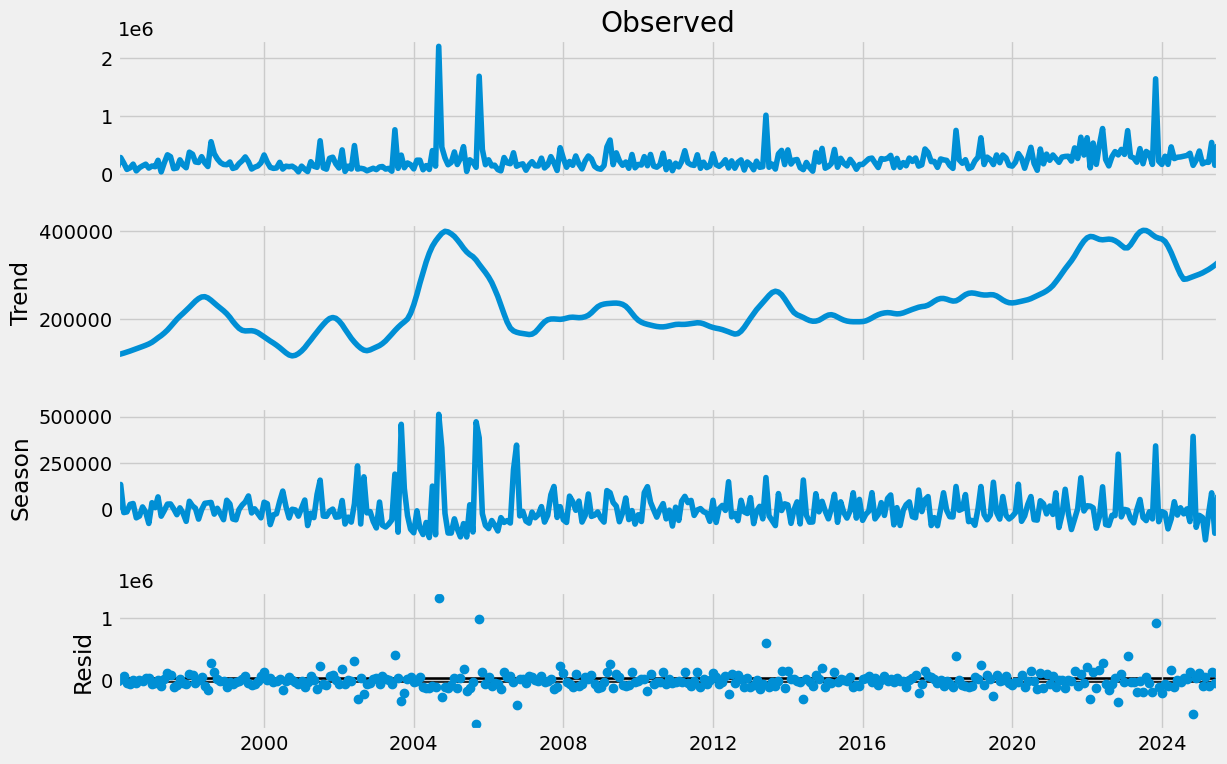

In [88]:
from statsmodels.tsa.seasonal import STL

#Fixing/Converting PeriodIndex:
if isinstance(decomp_data.index, pd.PeriodIndex):
    decomp_data.index = decomp_data.index.to_timestamp()

#Cleaning any of the data if it is having trouble with an interpolation
df_clean = decomp_data.interpolate(method='time')

#Run STL
stl = STL(df_clean, period=12)
result = stl.fit()

#Plot all parts of the decomp
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

The decomposition was having a lot of trouble when I was first working on it. I was able to get a the plot to work eventually with a different command and some interpolation. The data shows that there is some minor seaonal variation but that variation is much more prominent now after 2020. The housing market has shifted quite a bit and since covid there have been a lot of changes to interest rates and affordability. There is a seaosnal variation for this market year over year. Recently, we are seeing larger seaonal trends in that data. Additionally, you can see deviations in the residuals at that time as well. You can also see this in the early 2000s to 2008. We had a housing crisis in 2008 that caused the line to remain quite flat afterwards.
The trend of teh data shows pretty consistent homebuying with a spike after covid and downfall cause of the current high prices and interest rates.

### 4) Testing for Stationarity

In [89]:
#The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
#an array of numbers. This is why you need to also define a function that prints the correct output from that array.
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

#Apply the d_F test using the function on the time series
dickey_fuller(df_data['value'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.230152e+01
p-value                        7.431692e-23
Number of Lags Used            5.100000e+01
Number of Observations Used    3.188100e+04
Critical Value (1%)           -3.430555e+00
Critical Value (5%)           -2.861631e+00
Critical Value (10%)          -2.566818e+00
dtype: float64


This information shows that the test statistic is smaller than the critical values and I can reject the null hypothesis. This states that the data is stationary but it it is not statistically significant in its stationary

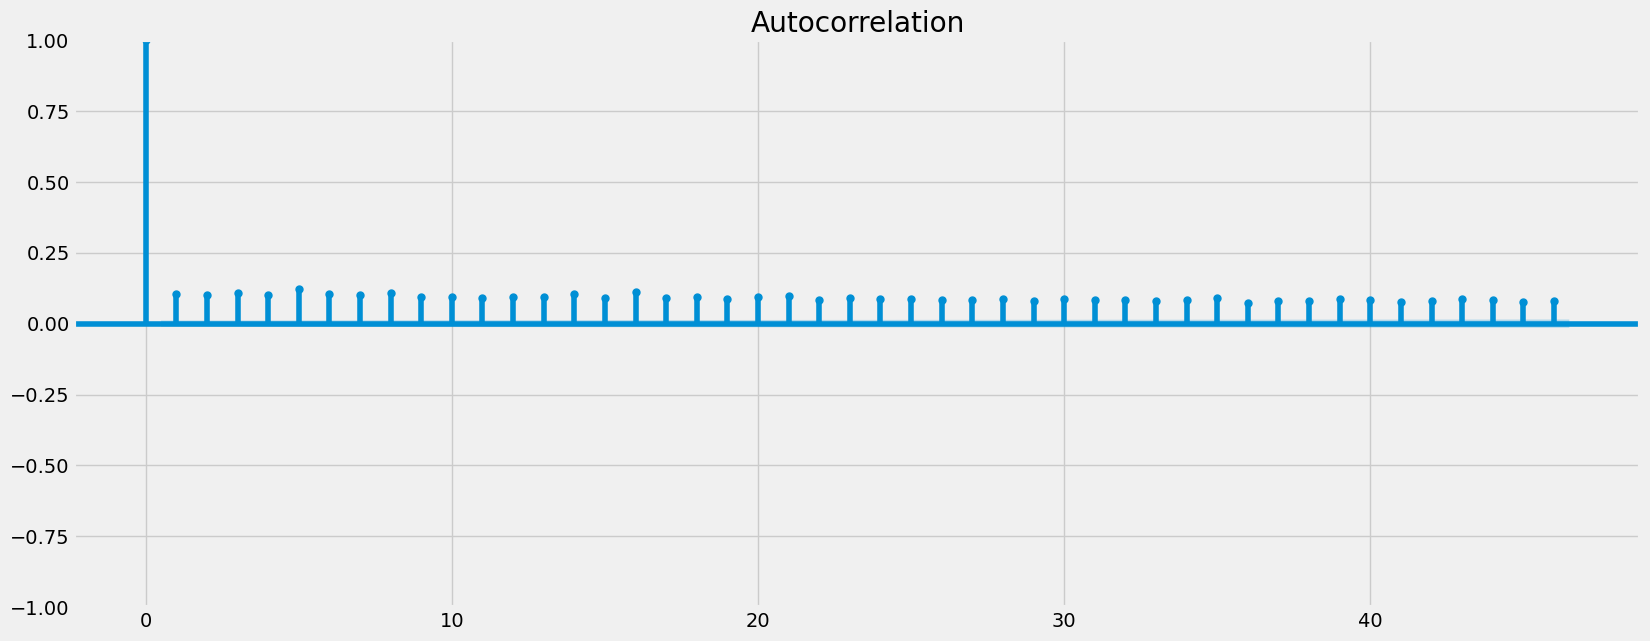

In [91]:
#Import and review plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_data, alpha=0.05)
plt.show()

Not able to see the blue confidence interval shading here even after manually setting it. Going to conduct a round of differencing to check again.

### 5) Stationarizing the Data

In [92]:
#attempting to difference the data with the previous date
data_diff = df_data - df_data.shift(1)
data_diff.dropna(inplace = True)
data_diff.head()

In [95]:
data_diff.columns

Index(['value'], dtype='object')

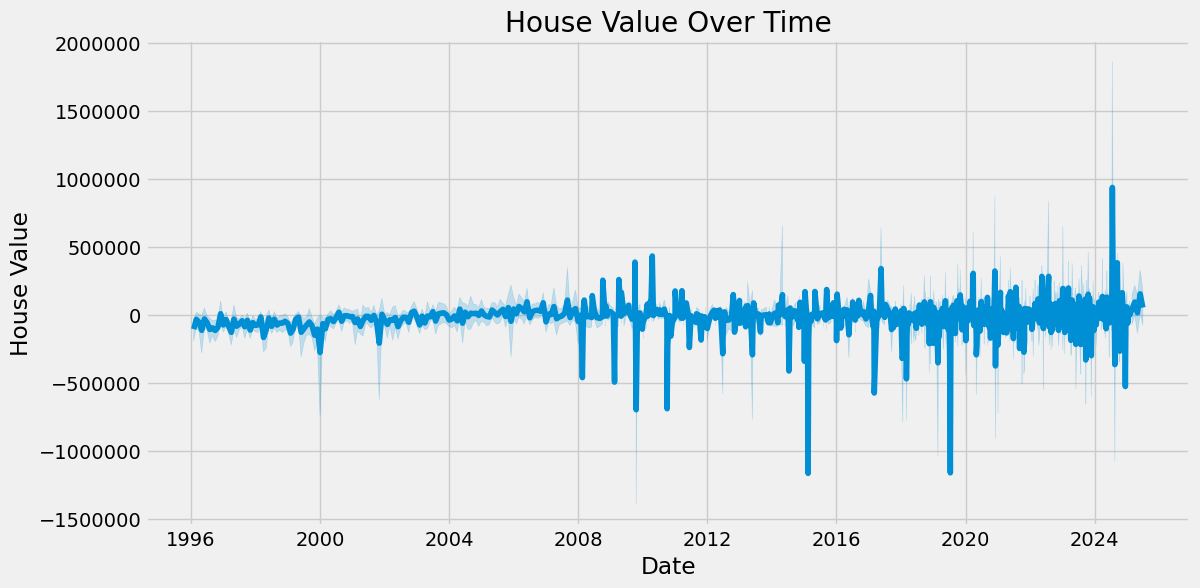

In [98]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data_diff, x='datetime', y='value')

plt.xlabel('Date')
plt.ylabel('House Value')
plt.title('House Value Over Time')
plt.grid(True)

plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.show()

In [99]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                   -39.834747
p-value                            0.000000
Number of Lags Used               51.000000
Number of Observations Used    31880.000000
Critical Value (1%)               -3.430555
Critical Value (5%)               -2.861631
Critical Value (10%)              -2.566818
dtype: float64


The null hypothesis is again true here and the data is stationary. The issue with it is the autocorrelation below. I am not seeing the blue shading for the confidence intervals and teh first two points are likely extremes as well. Going to try a log transformation next.

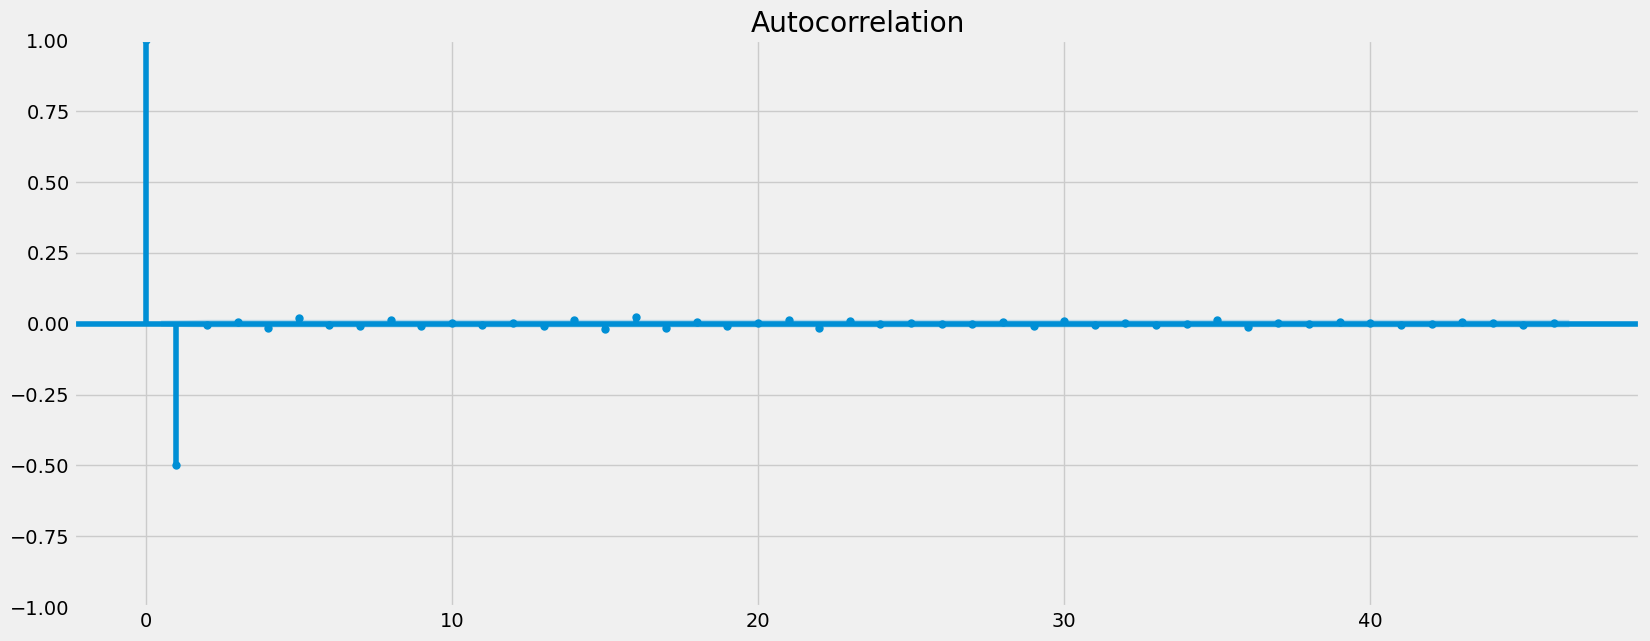

In [100]:
plot_acf(data_diff)
plt.show()

In [104]:
#round 2 of transforming the data with a log transformation
data_log = df_data.apply(np.log)
data_log.dropna(inplace = True)
data_log = data_log[np.isfinite(data_log)]  # remove inf
data_log.head()

,value
datetime,
1998-01-31,12.733310
1998-03-31,12.185436
1998-05-31,12.145016
1998-07-31,13.228723
2004-02-29,12.367495


In [107]:
#did not converge because of infinite values after log transformation.
dickey_fuller(data_log)

Dickey-Fuller Stationarity test:


MissingDataError: exog contains inf or nans

Logging the data led to some infinites that were not getting removed even with the code above. The log transformation did not seem to function as I had hoped. Overall, the data was considered stationary prior to my initial differencing. I was unable to find statistical signficance via these tests but I enjoyed the opportunity to try these test and transformations.

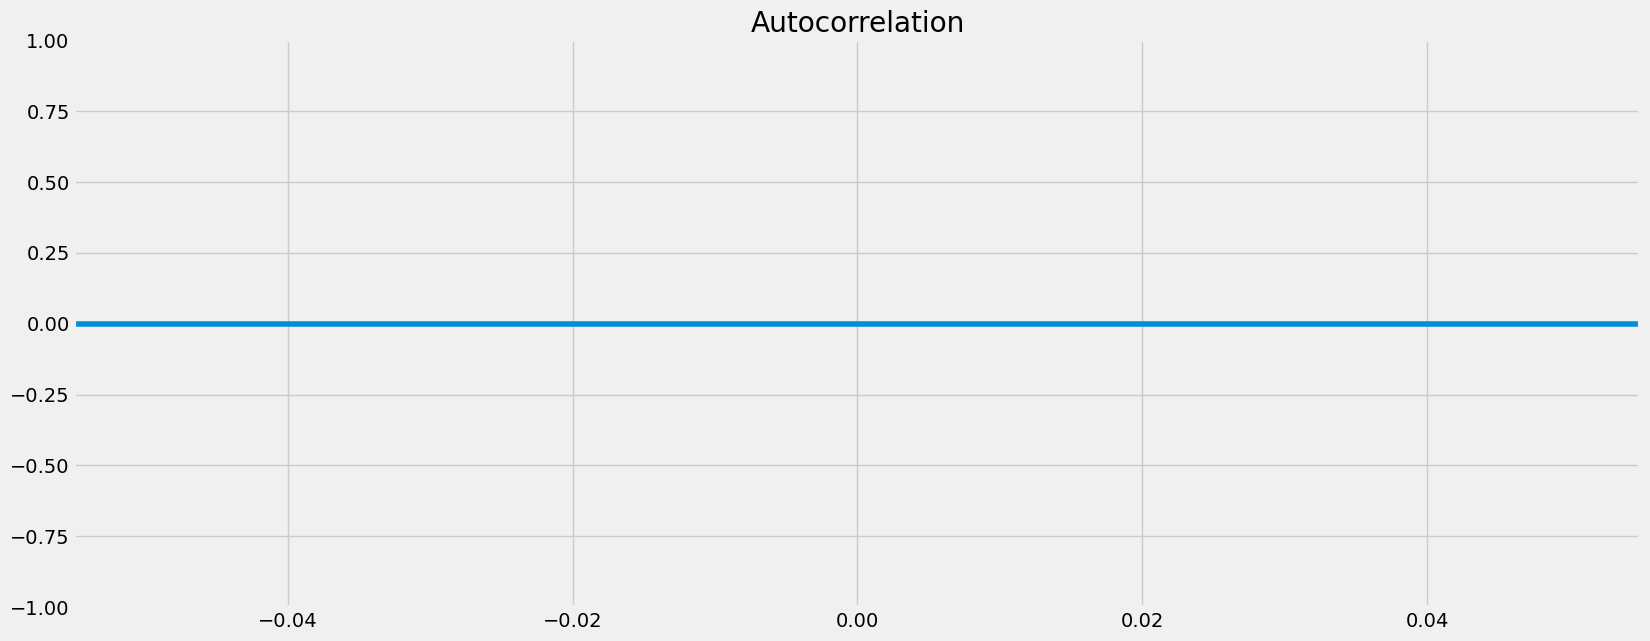

In [106]:
plot_acf(data_log)
plt.show()